In [12]:
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm

In [13]:
def calculate_weights(val1, val2):
    
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)

In [14]:
def dice_metric(predicted, target):
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

In [15]:
def train(model, data_in, loss, optim, max_epochs, model_dir, test_interval=1 , device=torch.device("cuda:0")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    train_loader, test_loader = data_in

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        for batch_data in train_loader:
            
            train_step += 1

            volume = batch_data["volume"]
            label = batch_data["label"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)
            
            train_loss = loss(outputs, label)
            
            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(
                f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                f"Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-'*20)
        
        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
        
        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % test_interval == 0:

            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in test_loader:

                    test_step += 1

                    test_volume = test_data["volume"]
                    test_label = test_data["label"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)
                    
                    test_outputs = model(test_volume)
                    
                    test_loss = loss(test_outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric
                    
                
                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        model_dir, "best_metric_model.pth"))
                
                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")



In [16]:
def show_patient(data, SLICE_NUMBER=1, train=True, test=False):
    """
    This function is to show one patient from your datasets, so that you can si if the it is okay or you need 
    to change/delete something.

    `data`: this parameter should take the patients from the data loader, which means you need to can the function
    prepare first and apply the transforms that you want after that pass it to this function so that you visualize 
    the patient with the transforms that you want.
    `SLICE_NUMBER`: this parameter will take the slice number that you want to display/show
    `train`: this parameter is to say that you want to display a patient from the training data (by default it is true)
    `test`: this parameter is to say that you want to display a patient from the testing patients.
    """

    check_patient_train, check_patient_test = data

    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)

    
    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient["volume"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient["label"][0, 0, :, :, SLICE_NUMBER])
        plt.show()
    
    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient["volume"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient["label"][0, 0, :, :, SLICE_NUMBER])
        plt.show()

In [17]:
def calculate_pixels(data):
    val = np.zeros((1, 2))

    for batch in tqdm(data):
        batch_label = batch["label"] != 0
        _, count = np.unique(batch_label, return_counts=True)

        if len(count) == 1:
            count = np.append(count, 0)
        val += count

    print('The last values:', val)
    return val

(768, 768, 3)


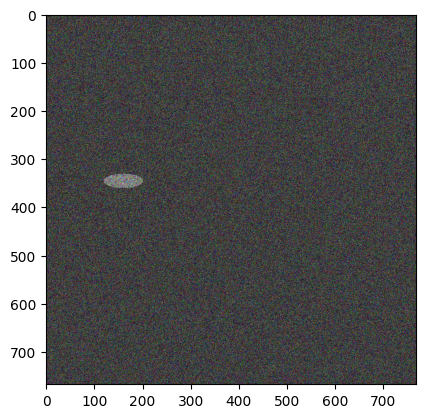

In [88]:
import numpy as np
import matplotlib.pyplot as plt


x = np.arange(768)
y = np.arange(768)
X, Y = np.meshgrid(x, y)

#cx, cy = 32, 32

cx = np.random.randint(100, 768-100)
cy = np.random.randint(100, 768-100)

#a, b = 20, 10
a = np.random.randint(10, 100)
b = np.random.randint(10, 100)

dist = ((X - cx)**2 / a**2) + ((Y - cy)**2 / b**2)
mask = (dist <= 1).astype(float)

#color = np.random.rand(768, 768, 3)
#color = 0.5 + 0.5 * np.random.rand(768, 768, 3)
color = 0.5 * np.random.rand(768, 768, 3)

ellipse = mask[:, :, None] * color

image = np.random.sample((768, 768, 3)) * 0.5

image += ellipse

plt.imshow(image)

plt.show()

In [ ]:
w_size = 256
train_num = 8192
train_x = np.zeros((train_num, w_size, w_size,3), dtype='float32')
train_y = np.zeros((train_num, w_size, w_size,1), dtype='float32')

img_l = np.random.sample((w_size, w_size, 3))*0.5
img_h = np.random.sample((w_size, w_size, 3))*0.5 + 0.5

radius_min = 10
radius_max = 30